<a href="https://colab.research.google.com/github/lauren-forti/Programming-for-Data-Science/blob/main/forti_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
# Type 3: Individual Project: Data Analysis and Modeling
## Lauren Forti
## 4/17/2021

# **1. Introduction**

## A. Background

It was considered taboo for women in the United States to write up until the 19th century. While the number of female American authors has exponentially increased with the rise of women's rights and feminism, the United States still has ways to go with gender equality.

The purpose of this study was to analyze biases against gender and birthplace in the literary world and how they intersect. Just how far have we come and where exactly has the progress been made?

[Goodreads](https://www.goodreads.com/) is a website for rating and reviewing books. The "[goodreads books/author data](https://www.kaggle.com/brosen255/goodreads-books)" dataset from Kaggle has author and book information for over 20,000 books. The books included are some of the most popular and highly regarded on the site.

In the study, different statistics were calculated and machine learning models built and evaluated to understand the different factors that go into predicting an author's gender based on book reviews. Then whether or not being born in the U.S. influenced how U.S. Goodreads users' ratings was analyzed.

## B. Questions

**1. Is there a discrepancy in the ratings for male versus female authors, or are they equal?**

No, the ratings are more or less equal.

**2. Is there a trend in readers' taste based on gender? ie Can a book's author's gender be predicted from parts of a book review? If so, which factors**

Yes, according to decision tree model the major factors in predicting the author's gender are the length of the book and the popularity.

**3. Are these factors the same for authors born in the United States versus other countries?**

For authors born in the U.S., the popularity is a major factor. For authors born outside the U.S., the only factor is the rating of the book.

## C. Outline

* Introduction of dataset and basic characteristics

* Analysis of discrepancy for average rating per book and author between female authors vs male authors.

* Analysis of structure and factors in predicting author gender via **KNN model, Decision Tree,** and **ANN model**. Grid searches are conducted to find and build the optimal models. The accuracy and confidence intervals are computed. Confusion matrices are made.

* Analysis of authors born inside the U.S. via **Decision Tree** model. 

* Analysis of authors born outside the U.S. via **Decision Tree** model. 

* Plot decision surfaces for both models and discuss any differences and what this reveals about the United States' attitudes

* Conclusion/Discussion of results

* Appendix

# **2. Data**

### A. About the Dataset

In [ ]:
# preamble to be able to run notebooks in Colab
from google.colab import drive
import sys

# mount the drive
drive.mount('/content/drive', force_remount=True) 

# useful folders
notes_home = "/content/drive/Shareddrives/CSC310/ds/notes/"
user_home = "/content/drive/Shareddrives/CSC310 Final/"
    
# insert the notes folder into the path so we can include assets modules etc
sys.path.insert(1,notes_home)

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import regex as re

In [ ]:
# get data
df = pd.read_csv("/content/drive/Shareddrives/CSC310 Final/good_reads_final.csv")

# visually inspect first ten rows of DataFrame
df.head(n=10)

,author_average_rating,author_gender,author_genres,author_id,author_name,author_page_url,author_rating_count,author_review_count,birthplace,book_average_rating,book_fullurl,book_id,book_title,genre_1,genre_2,num_ratings,num_reviews,pages,publish_date,score
0,4.01,female,"historical-fiction,",74489,Victoria Thompson\n,/author/show/74489.Victoria_Thompson,74399,6268,United States\n,4.02,https://www.goodreads.com/book/show/686717.Mur...,686717,\n Murder on St. Mark's Place\n,Mystery,Historical,5260,375,277,2000,3230
1,4.15,male,"literature-fiction,mystery-thrillers,",706255,Stieg Larsson\n,/author/show/706255.Stieg_Larsson,3726435,142704,Sweden\n,4.13,https://www.goodreads.com/book/show/2429135.Th...,2429135,\n The Girl with the Dragon Tattoo\n,Fiction,Mystery,2229163,65227,465,August 2005,3062
2,4.00,female,"romance,",5618190,Mimi Jean Pamfiloff\n,/author/show/5618190.Mimi_Jean_Pamfiloff,76496,7975,United States\n,3.99,https://www.goodreads.com/book/show/27833684-t...,27833684,\n Tailored for Trouble\n,Romance,Contemporary,2151,391,354,2016,4585
3,3.88,male,"fiction,memoir,",37871,José Donoso\n,/author/show/37871.Jos_Donoso,5522,489,Chile\n,4.14,https://www.goodreads.com/book/show/382975.The...,382975,\n The Obscene Bird of Night\n,Fiction,Magical Realism,1844,173,438,1970,1533
4,4.10,female,"young-adult,fantasy,",36122,Patricia C. Wrede\n,/author/show/36122.Patricia_C_Wrede,291013,13453,United States\n,4.01,https://www.goodreads.com/book/show/64207.Sorc...,64207,\n Sorcery & Cecelia: or The Enchanted Ch...,Fantasy,Young Adult,17051,1890,326,April 15th 1988,2105
5,3.77,male,"horror,",58947,Steve Niles\n,/author/show/58947.Steve_Niles,47938,3240,United States\n,3.80,https://www.goodreads.com/book/show/831829.30_...,831829,"\n 30 Days of Night, Vol. 1\n",Sequential Art,Sequential Art,17122,561,104,January 10th 2004,4372
6,4.16,female,"romance,",4833990,Jillian Dodd\n,/author/show/4833990.Jillian_Dodd,110522,9451,\n,3.95,https://www.goodreads.com/book/show/34804503-s...,34804503,\n Stalk Me\n,Young Adult,Romance,11684,1107,327,August 20th 2012,2396
7,3.94,female,"nonfiction,",7956,Mary Roach\n,/author/show/7956.Mary_Roach,321197,29747,United States\n,3.84,https://www.goodreads.com/book/show/5981308-bonk,5981308,\n Bonk: The Curious Coupling of Science ...,Nonfiction,Science,45963,4268,319,2008,2054
8,3.78,female,"fantasy,",155651,Nancy Baker\n,/author/show/155651.Nancy_Baker,1019,104,\n Canada\n,3.77,https://www.goodreads.com/book/show/266600.Kis...,266600,\n Kiss of the Vampire\n,Paranormal,Horror,594,42,278,January 1st 1993,1311
9,4.08,female,"young-adult,",274533,Simone Elkeles\n,/author/show/274533.Simone_Elkeles,481114,25166,United States\n,4.01,https://www.goodreads.com/book/show/544424.Lea...,544424,\n Leaving Paradise\n,Young Adult,Romance,40093,2375,303,April 1st 2007,1994


The data was cleaned by removing extraneous columns, dropping duplicates, and standardizing columns. The original dataset was sampled down to 10%.

In [ ]:
# get rid of extraneous columns
df2 = df.drop(['author_id', 'author_page_url', 'book_fullurl', 'book_id', 'publish_date', 'author_genres', 'score'], axis = 1)

# drop duplicates
df2 = df2.drop_duplicates()

# remove "\n" from select columns and standardize birthplace
df2['author_name'] = df2['author_name'].str.replace(r'\n','')
df2['book_title'] = df2['book_title'].str.replace(r'\n','')
df2['birthplace'] = df2['birthplace'].str.replace(r'[^a-zA-Z0-9]\n?','').str.strip()
df2['genre_2'] = df2['genre_2'].str.replace(r'See top shelves…', '')

# standardize pages column and convert to numerical data
df2['pages'] = df2['pages'].str.replace('[A-Za-z]', '')
df2['pages'] = pd.to_numeric(df2['pages'])

# sample 10% of data and renumber index
# initially df2 = df2.sample(frac=.1, random_state = 1, replace=True).reset_index(drop=True) was used
# but for the sake of consistency in the report numbers and discussion "replace" has been removed
df2 = df2.sample(frac=.1, random_state = 3).reset_index(drop=True)

# output first ten rows
df2.head(n=10)

,author_average_rating,author_gender,author_name,author_rating_count,author_review_count,birthplace,book_average_rating,book_title,genre_1,genre_2,num_ratings,num_reviews,pages
0,4.04,male,M. Scott Peck,92903,2972,UnitedStates,4.05,The Road Less Traveled: A New Psychology...,Psychology,Nonfiction,74344,1982,316
1,3.69,male,Megan Hart,86295,9537,,3.93,Broken,Adult Fiction,Romance,9368,920,384
2,4.14,male,Susan May Warren,52767,6708,,3.74,Heiress,Christian Fiction,Historical,1793,224,368
3,4.25,female,Cherise Sinclair,223455,12896,UnitedStates,4.40,To Command and Collar,Erotica,Adult Fiction,12543,626,341
4,3.96,female,Ruth Ozeki,90707,12045,UnitedStates,3.79,All Over Creation,Fiction,Food and Drink,4580,609,432
5,4.43,male,Hajime Isayama,297154,9213,Japan,4.52,"Attack on Titan: No Regrets, Volume 01",Sequential Art,Sequential Art,10035,238,192
6,3.97,male,Jeffrey Eugenides,1555682,57984,UnitedStates,3.84,The Virgin Suicides,Fiction,Contemporary,208261,8427,260
7,4.34,male,Paul Aertker,386,49,UnitedStates,4.20,Brainwashed,Mystery,Young Adult,244,25,308
8,4.03,male,Elliot Aronson,23786,1086,UnitedStates,4.25,The Social Animal,Psychology,Nonfiction,2629,124,512
9,4.27,male,Tite Kubo,443883,5580,Japan,4.22,"Bleach, Volume 01",Sequential Art,Fantasy,135567,1037,200


In [ ]:
# get # of rows in DataFrame
df2.shape[0]

2124

In [ ]:
# get # of columns in DataFrame
df2.shape[1]

13

There are 2,124 rows and 13 columns in the dataset after cleaning.

In [ ]:
# isolate independent variables
X = df2.drop(['author_gender'], axis = 1)

# isolate dependent variable
y = pd.DataFrame(df2['author_gender'])

### B. Target Variable

The target variable will be **author_gender**

In [ ]:
y['author_gender'].value_counts()

male      1173
female     951
Name: author_gender, dtype: int64

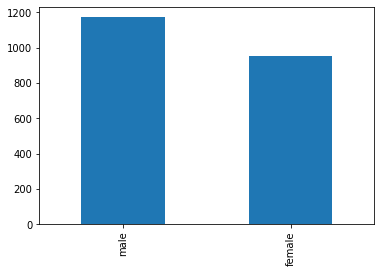

In [ ]:
# plot bar chart of labels
y['author_gender'].value_counts().plot.bar()

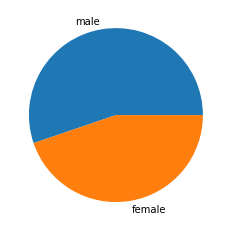

In [ ]:
# plot pie chart of labels
plot_series = y['author_gender'].rename('')
plot_series.rename('').value_counts().plot.pie()

The target variable is decently balanced.

### C. Independent Variables

In [ ]:
# get basic summary statistics of independent variables
X.describe()

,author_average_rating,author_rating_count,author_review_count,book_average_rating,num_ratings,num_reviews,pages
count,2124.000000,2.124000e+03,2124.000000,2124.000000,2.124000e+03,2124.00000,2124.000000
mean,3.961153,1.697299e+05,9077.148305,3.954647,4.551863e+04,2240.84322,332.572505
std,0.234349,5.067468e+05,21442.079842,0.292106,1.602567e+05,6448.04298,244.285463
min,2.890000,1.000000e+01,1.000000,2.370000,5.000000e+00,0.00000,3.000000
25%,3.820000,5.026750e+03,578.750000,3.780000,8.992500e+02,108.00000,237.000000
50%,3.960000,2.605300e+04,2277.000000,3.960000,4.427000e+03,373.50000,313.000000
75%,4.120000,1.143800e+05,8078.500000,4.150000,2.035475e+04,1498.25000,384.000000
max,5.000000,7.062081e+06,323074.000000,5.000000,2.504334e+06,102194.00000,4736.000000


Out of the 13 variables, 8 are numeric and 6 are categorical.

**Numeric:**
* author_average_rating (0 - 5)
* author_rating_count
* author_review_count
* book_average_rating (0 - 5)
* num_ratings
* num_reviews
* pages

**Categorical:**
* author_name
* birthplace
* book_title
* genre_1
* genre_2



### D. Basic Summary Statistics in the form of histograms and bar graphs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f116535acd0>,
      dtype=object)

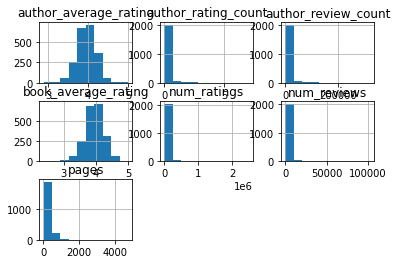

In [ ]:
# make histograms of all independent variables
X.hist()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


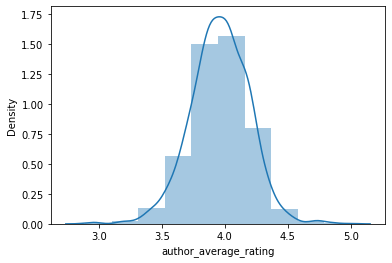

In [ ]:
null = sns.distplot(X['author_average_rating'], hist = True, kde = True, bins = 10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


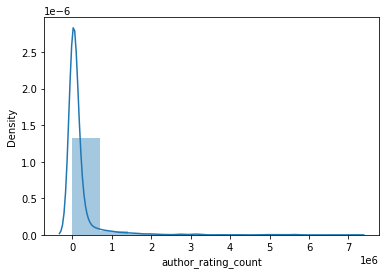

In [ ]:
null = sns.distplot(X['author_rating_count'], hist = True, kde = True, bins = 10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


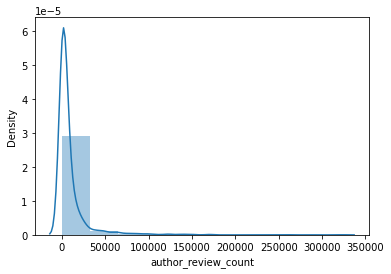

In [ ]:
null = sns.distplot(X['author_review_count'], hist = True, kde = True, bins = 10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


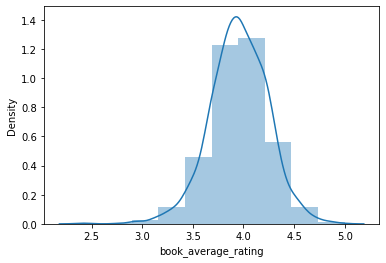

In [ ]:
null = sns.distplot(X['book_average_rating'], hist = True, kde = True, bins = 10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


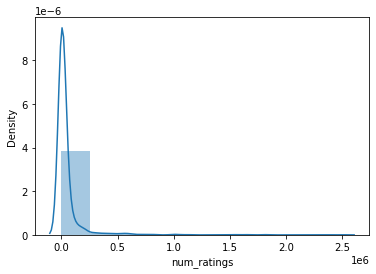

In [ ]:
null = sns.distplot(X['num_ratings'], hist = True, kde = True, bins = 10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


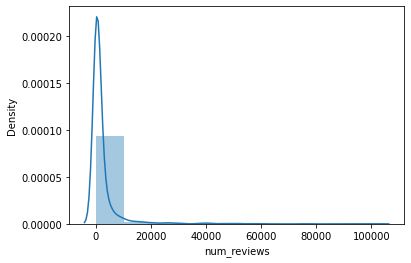

In [ ]:
null = sns.distplot(X['num_reviews'], hist = True, kde = True, bins = 10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


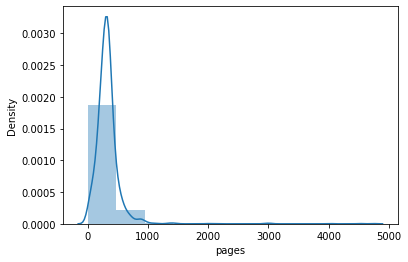

In [ ]:
null = sns.distplot(X['pages'], hist = True, kde = True, bins = 10)

# **3. Methods & Analysis**

## A. Basic Statistics

Basic statistics of male and female author ratings were calculated to see if there is a discrepancy in the general ratings. First was the average rating of male and female authors and average rating per book by male and female authors.

In [ ]:
# get df for female authors
f_df = df2[df2['author_gender'] == 'female']
# get average author & book ratings
f_aut_avg = f_df['author_average_rating'].mean()
f_bk_avg = f_df['book_average_rating'].mean()

# get df for male authors
m_df = df2[df2['author_gender'] == 'male']
m_bk_avg = m_df['book_average_rating'].mean()
# get average author & book ratings
m_aut_avg = m_df['author_average_rating'].mean()

print('Average Author Rating (0 - 5)')
print('---------------------------')
print('Male: {}'.format(m_aut_avg))
print('Female: {}'.format(f_aut_avg))
print('Difference: {}'.format(m_aut_avg - f_aut_avg))
print('')
print('Average Book Rating (0 - 5)')
print('---------------------------')
print('Male: {}'.format(m_bk_avg))
print('Female: {}'.format(f_bk_avg))
print('Difference: {}'.format(m_bk_avg - f_bk_avg))

Average Author Rating (0 - 5)
---------------------------
Male: 3.967118499573743
Female: 3.9537960042061
Difference: 0.013322495367642961

Average Book Rating (0 - 5)
---------------------------
Male: 3.963827791986354
Female: 3.943322818086227
Difference: 0.020504973900127066


There is a slight discrepancy of ratings between male and female where male authors have slightly higher ratings. The difference is so small that it is almost neglibile. This was visualized by the below. Bar graphs can be viewed in Appendix 1.1 and 1.2.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


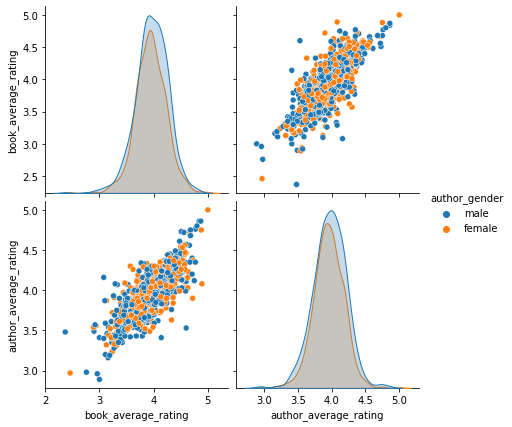

In [ ]:
sns.pairplot(df2, hue = 'author_gender', size = 3, vars = ['book_average_rating', 'author_average_rating'])

Overall, the graphs are pretty even between female and male authors. As the average book rating increases, so does the average rating of the author. Though the highest overall rating is a female author, most authors with ratings above a 4.5 are male.

## B. Machine Learning Models

Next were the grid searches to find optimal different machine learning models (KNN, Decision Trees, and MLP) to see which numerical factors in a book review would predict the author's gender most accurately. 

The first model tested was a KNN.

### **1. KNN Model**

A grid search was conducted to find and build the optimal KNN model. The accuracy, confidence interval, and confusion matrix were output.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from assets.confint import classification_confint

# get data
X = df2.drop(['author_name', 'book_title', 'birthplace', 'genre_1', 'genre_2', 'author_gender'], axis = 1)
y = df2['author_gender']

# KNN
KNN_model = KNeighborsClassifier()

# grid search
KNN_param_grid = {'n_neighbors': list(range(1,14))}
KNN_grid = GridSearchCV(KNN_model, KNN_param_grid, cv=3)
KNN_grid.fit(X, y)
# output best parameters
print("Grid Search: best parameters: {}".format(KNN_grid.best_params_))
print("")

# accuracy of best model
best_KNN_model = KNN_grid.best_estimator_
predict_y_KNN = best_KNN_model.predict(X)
acc_KNN = accuracy_score(y, predict_y_KNN)
lb_KNN,ub_KNN = classification_confint(acc_KNN,X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc_KNN,lb_KNN,ub_KNN))
print("")

# build the confusion matrix
labels = ['male', 'female']
cm_KNN = confusion_matrix(y, predict_y_KNN, labels=labels)
cm_df_KNN = pd.DataFrame(cm_KNN, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(cm_df_KNN))

Grid Search: best parameters: {'n_neighbors': 3}

Accuracy: 0.76 (0.75,0.78)

Confusion Matrix:
        male  female
male     926     247
female   253     698


The optimal number of neighbors is **3.** This shows that there is clustering within the model.

We can say with 95% confidence that the accuracy of the optimal **KNN model** is between .75 and .78.

In [ ]:
y.value_counts()

male      1173
female     951
Name: author_gender, dtype: int64

The model makes some mistakes when predicting gender. It incorrectly categorized 247 **male** authors as **female** authors and 253 **female** authors as **male** authors.

### **2. Decision Tree Model**

First the neccessary packages and data were imported. A grid search was conducted to find and build the optimal decision tree model. The range was found by building a decision tree without a max depth specified (see Appendix 2.1)

In [ ]:
# models
from sklearn.tree import DecisionTreeClassifier
from assets.treeviz import tree_print

# model evaluation routines
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from assets.confint import classification_confint

# get data
X  = df2.drop(['author_gender', 'author_name', 'book_title', 'birthplace', 'genre_1', 'genre_2'], axis = 1)
y = df2['author_gender']

In [ ]:
# decision trees
tree_model = DecisionTreeClassifier(random_state=1)

# grid search
tree_param_grid = {'max_depth': list(range(1, 27)), 'criterion': ['entropy','gini'] }
tree_grid = GridSearchCV(tree_model, tree_param_grid, cv=5)
tree_grid.fit(X, y)
print("Grid Search: best parameters: {}".format(tree_grid.best_params_))

tree_best_model = tree_grid.best_estimator_
# print best tree
tree_print(tree_best_model, X)

Grid Search: best parameters: {'criterion': 'gini', 'max_depth': 11}
if pages =< 591.0: 
  |then if num_ratings =< 50216.0: 
  |  |then if author_review_count =< 226.5: 
  |  |  |then if num_reviews =< 67.0: 
  |  |  |  |then if author_average_rating =< 3.8549998998641968: 
  |  |  |  |  |then if pages =< 72.5: 
  |  |  |  |  |  |then female
  |  |  |  |  |  |else if author_review_count =< 58.0: 
  |  |  |  |  |  |  |then if pages =< 229.0: 
  |  |  |  |  |  |  |  |then male
  |  |  |  |  |  |  |  |else if num_ratings =< 81.0: 
  |  |  |  |  |  |  |  |  |then if author_review_count =< 9.0: 
  |  |  |  |  |  |  |  |  |  |then female
  |  |  |  |  |  |  |  |  |  |else male
  |  |  |  |  |  |  |  |  |else if num_ratings =< 283.0: 
  |  |  |  |  |  |  |  |  |  |then if num_ratings =< 148.5: 
  |  |  |  |  |  |  |  |  |  |  |then male
  |  |  |  |  |  |  |  |  |  |  |else female
  |  |  |  |  |  |  |  |  |  |else male
  |  |  |  |  |  |  |else if book_average_rating =< 3.2699999809265137: 


The accuracy score and confidence interval were calculated and confusion matrix built.

In [ ]:
# accuracy of best model with confidence interval
tree_predict_y = tree_best_model.predict(X)
tree_acc = accuracy_score(y, tree_predict_y)
tree_lb,tree_ub = classification_confint(tree_acc,X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(tree_acc,tree_lb,tree_ub))
print("")

# build the confusion matrix
labels = ['male', 'female']
tree_cm = confusion_matrix(y, tree_predict_y, labels=labels)
tree_cm_df = pd.DataFrame(tree_cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(tree_cm_df))

Accuracy: 0.77 (0.75,0.79)

Confusion Matrix:
        male  female
male     747     426
female    67     884


We can say with 95% confidence that the accuracy of the **decision tree model** is between .75 and .79.

In [ ]:
y.value_counts()

male      1173
female     951
Name: author_gender, dtype: int64

The confusion matrix makes more mistakes categorizing male authors. There are 426 **male** authors categorized as **female** authors and 67 **female** authors incorrectly categorized as **male** authors.

The optimal tree is very complex and not very intuitive. 

The first few levels:
```
if pages =< 591.0: 
  |then if num_ratings =< 50216.0: 
  |  |then if author_review_count =< 226.5: 
  |  |  |then if num_reviews =< 67.0: 
  |  |  |  |then if author_average_rating =< 3.8549998998641968: 
  |  |  |  |  |then if pages =< 72.5: 
  |  |  |  |  |  |then female
  ...
  |else if author_rating_count =< 333.5: 
  |  |then female
```
If the number of pages in the book is equal to or under 591 and the number of book ratings is equal to or less than 226, then there are many other conditions required to predict the author's gender.

However, if the book's pages are equal to or under 591 and the number of ratings is more than 226, it is not nearly as complex - then the author is female. 

The variables **pages**, **num_ratings**, and **author_rating_count** are the most important factors in determining the author's gender. This suggests that popularity is a major factor. To see the plotted decision surfaces, see Appendix 2.2.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


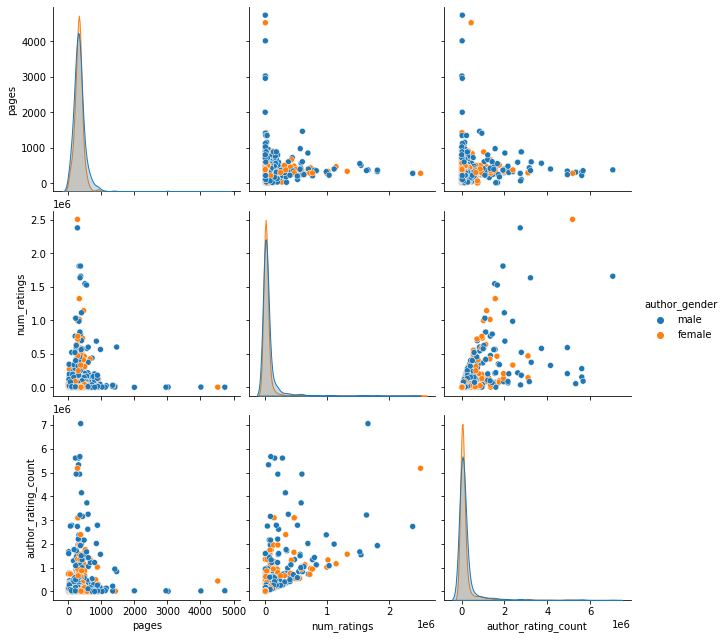

In [ ]:
sns.pairplot(df2, hue = 'author_gender', size = 3, vars = ['pages', 'num_ratings', 'author_rating_count'])

According to the graph above, female authors tend to have fewer pages in their books. Male authors are rated much more frequently than female authors with the same number of pages. 

In [ ]:
# get average book length
X['pages'].mean()

332.57250470809794

The average book in the dataset has 333 pages. Even if the book is almost twice as long as average, if there are not many ratings then the author is likely to be **female**.

### **3. ANN**

ANN model with **tanh** as the activation was built and the accuracy score and confusion matrix was output.

In [ ]:
# set up
np.set_printoptions(formatter={'float_kind':"{:3.2f}".format})
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from assets.confint import classification_confint
from sklearn.metrics import confusion_matrix

# get data
X = df2.drop(['author_gender', 'author_name', 'book_title', 'birthplace', 'genre_1', 'genre_2'], axis = 1)
y = df2['author_gender']

# get number of independent variables
print("There are {} independent variables".format(X.shape[1]))

There are 7 independent variables


In [ ]:
# neural network
# NOTE: a good rule of thumb for MLP starting point:
# a) 1 hidden layer
# b) the number of nodes in hidden layer: no_node = 2 * no_independents_vars
#
ANN_model = MLPClassifier(hidden_layer_sizes=(14,), activation='tanh', max_iter=1000, random_state=1)

# train and test the model
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=3)
ANN_model.fit(train_X, train_y)
ANN_predict_y = ANN_model.predict(X)

# accuracy score and confidence interval
ANN_acc = accuracy_score(y, ANN_predict_y)
ANN_lb, ANN_ub = classification_confint(ANN_acc, test_X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(ANN_acc, ANN_lb, ANN_ub))
print("")

# build the confusion matrix
labels = ['male', 'female']
ANN_cm = confusion_matrix(y, ANN_predict_y, labels=labels)
ANN_cm_df = pd.DataFrame(ANN_cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(ANN_cm_df))

Accuracy: 0.54 (0.50, 0.59)

Confusion Matrix:
        male  female
male    1136      37
female   930      21


An ANN with the activation as **relu** was conducted as well as a more comprehensive ANN grid search, but even after 1.5 million iterations, neither converged. Please see Appendix 3.1 and 3.2.

### **4. Accuracy Summary**

To recap the accuracies for the different models:

In [ ]:
print("KNN:\n{:3.2f} ({:3.2f},{:3.2f})".format(acc_KNN,lb_KNN,ub_KNN))
print("")
print("Decision Tree:\n{:3.2f} ({:3.2f},{:3.2f})".format(tree_acc,tree_lb,tree_ub))
print("")
print("ANN:\n{:3.2f} ({:3.2f},{:3.2f})".format(ANN_acc, ANN_lb, ANN_ub))

KNN:
0.76 (0.75,0.78)

Decision Tree:
0.77 (0.75,0.79)

ANN:
0.54 (0.50,0.59)


The **ANN model** is almost irrelevant. The accuracy score is low and the confidence interval does not overlap the other models. The confusion matrix illustrates the model's tendency to categorize authors as **male**.

The **KNN model** and **Decision Tree model** confidence intervals overlap.The difference in model performance of these two models is not statistically significant. The **Decision Tree** is the most relevant model for the purpose of understanding which factors help predict gender. 

##**C. Author Birthplace Analysis**

Because the **Decision Tree** was the best model for the whole dataset, the subsets of authors born in U.S. and authors born outside the U.S. were also analyzed with **Decision Trees**. 

### **1. Authors Born Outside U.S.**

Authors born outside the United States were isolated into their own DataFrame and basic statistics calculated.

In [ ]:
# remove blank birthplaces
dfcopy = df2
dfcopy['birthplace'].replace('',np.NaN, inplace=True)
dfcopy.dropna(subset=['birthplace'], inplace=True)

# make copy of df and get authors born outside of United States
df3 = dfcopy[dfcopy['birthplace']!='UnitedStates']
df3.reset_index(drop=True, inplace=True)
df3.head(n=10)

,author_average_rating,author_gender,author_name,author_rating_count,author_review_count,birthplace,book_average_rating,book_title,genre_1,genre_2,num_ratings,num_reviews,pages
0,4.43,male,Hajime Isayama,297154,9213,Japan,4.52,"Attack on Titan: No Regrets, Volume 01",Sequential Art,Sequential Art,10035,238,192
1,4.27,male,Tite Kubo,443883,5580,Japan,4.22,"Bleach, Volume 01",Sequential Art,Fantasy,135567,1037,200
2,3.53,male,Leah Kaminsky,701,123,Australia,4.60,The Hollow Bones,Historical,War,5,2,336
3,4.76,male,Mustafa Kemal Atatürk,3374,112,Greece,4.77,Nutuk,History,Asian Literature,2865,80,610
4,3.89,male,John Stuart Mill,69943,1917,England,3.95,On Liberty,Philosophy,Politics,24759,733,187
5,3.77,male,Voltaire,220522,8074,France,3.76,Candide,Classics,Fiction,192652,6445,129
6,3.84,female,Joanne Harris,225794,16138,UnitedKingdom,3.85,Five Quarters of the Orange,Fiction,Historical,29099,2249,307
7,3.80,male,Guillermo del Toro,151922,13412,Mexico,3.78,The Strain,Horror,Science Fiction,72322,6189,403
8,4.20,male,Carina Bartsch,5331,544,Germany,4.20,Kirschroter Sommer,Romance,New Adult,2574,277,511
9,4.17,male,Shannon Mayer,155351,9570,Canada,3.85,Sundered,Horror,Horror,1951,234,122


In [ ]:
# get df for female authors
n_US_f_df = df3[df3['author_gender'] == 'female']
# get average author & book ratings
n_US_f_aut_avg = n_US_f_df['author_average_rating'].mean()
n_US_f_bk_avg = n_US_f_df['book_average_rating'].mean()

# get df for male authors
n_US_m_df = df3[df3['author_gender'] == 'male']
n_US_m_bk_avg = n_US_m_df['book_average_rating'].mean()
# get average author & book ratings
n_US_m_aut_avg = n_US_m_df['author_average_rating'].mean()

print('Average Author Rating (0 - 5)')
print('---------------------------')
print('Male: {}'.format(n_US_m_aut_avg))
print('Female: {}'.format(n_US_f_aut_avg))
print('Difference: {}'.format(n_US_m_aut_avg - n_US_f_aut_avg))
print('')
print('Average Book Rating (0 - 5)')
print('---------------------------')
print('Male: {}'.format(n_US_m_bk_avg))
print('Female: {}'.format(n_US_f_bk_avg))
print('Difference: {}'.format(n_US_m_bk_avg - n_US_f_bk_avg))

Average Author Rating (0 - 5)
---------------------------
Male: 3.9810023866348425
Female: 3.954203539823008
Difference: 0.02679884681183431

Average Book Rating (0 - 5)
---------------------------
Male: 3.9999999999999973
Female: 3.9466814159292056
Difference: 0.05331858407079171


The difference in ratings between male and female authors born outside of the united states is very small. It is important to note that there are significantly fewer female authors than male authors in this subset. It is also important to note that while the difference is small, it is significantly higher compared to the differences in genders in the overall dataset and the subset of authors born in the U.S.. There is a slight bias in U.S. readers to rate male authors higher than female authors.

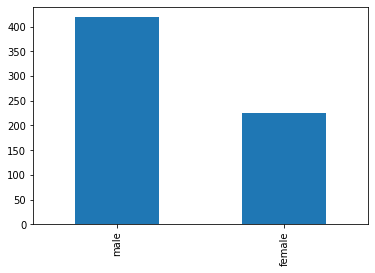

In [ ]:
# plot bar chart of labels
df3['author_gender'].value_counts().plot.bar()

A grid search was conducted and the optimal decision tree model built. To see how the max range was found, see Appendix 2.3. The accuracy and the confidence interval were output.

In [ ]:
# get data
X  = df3.drop(['author_gender', 'author_name', 'book_title', 'birthplace', 'genre_1', 'genre_2'], axis = 1)
y = df3['author_gender']

# decision tree
n_US_tree_model = DecisionTreeClassifier(random_state=1)

# grid search
n_US_tree_param_grid = {'max_depth': list(range(1, 25)), 'criterion': ['entropy','gini'] }
n_US_tree_grid = GridSearchCV(n_US_tree_model, n_US_tree_param_grid, cv=5)
n_US_tree_grid.fit(X, y)
print("Grid Search: best parameters: {}".format(n_US_tree_grid.best_params_))

n_US_tree_best_model = n_US_tree_grid.best_estimator_
# print best tree
tree_print(n_US_tree_best_model, X)
print('')

# accuracy of best model with confidence interval
n_US_tree_predict_y = n_US_tree_best_model.predict(X)
n_US_tree_acc = accuracy_score(y, n_US_tree_predict_y)
n_US_tree_lb,n_US_tree_ub = classification_confint(n_US_tree_acc,X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(n_US_tree_acc,n_US_tree_lb,n_US_tree_ub))
print('')

# build the confusion matrix
labels = ['male','female']
n_US_tree_cm = confusion_matrix(y, n_US_tree_predict_y, labels=labels)
n_US_tree_cm_df = pd.DataFrame(n_US_tree_cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(n_US_tree_cm_df))

Grid Search: best parameters: {'criterion': 'entropy', 'max_depth': 1}
if book_average_rating =< 4.055000066757202: 
  |then male
  |else male
<->
Tree Depth:  1

Accuracy: 0.65 (0.61,0.69)

Confusion Matrix:
        male  female
male     419       0
female   226       0


This model is extremely flawed, as it categorizes all author genders as **male**. This may be due to the unbalanced author genders in the subset.

When examining a graph of **book_average_rating**, there is not a clear pattern of author gender. Looking at the decision tree built when max depth is not specified (Appendix 2.3), ratings of the books and authors are a determining factor in the author's gender.

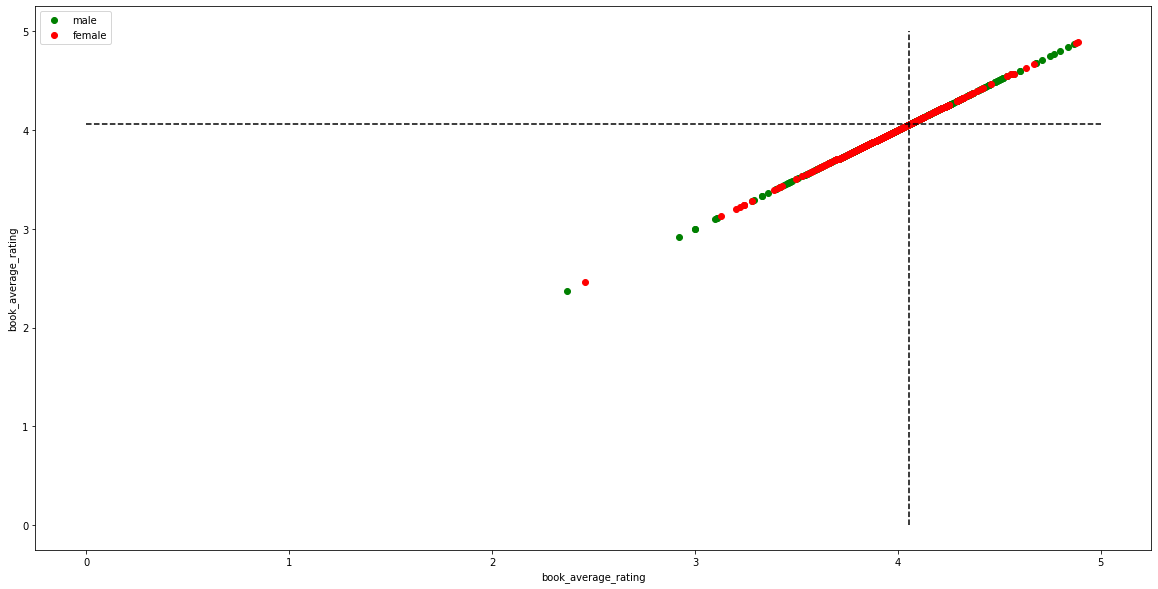

In [ ]:
# isolating labels
n_US_f_df = df3[df3['author_gender'] == 'female']
n_US_m_df = df3[df3['author_gender'] == 'male']

# scatter plot of the data
plt.figure(figsize = (20, 10))
plt.plot(n_US_m_df['book_average_rating'], n_US_m_df['book_average_rating'], 'go')
plt.plot(n_US_f_df['book_average_rating'], n_US_f_df['book_average_rating'], 'ro')
plt.xlabel('book_average_rating')
plt.ylabel('book_average_rating')
plt.legend(['male', 'female'])

# plotting the decision surfaces
# pages
plt.plot([4.055000066757202,4.055000066757202], [0,5], 'k--')
plt.plot([0,5], [4.055000066757202,4.055000066757202], 'k--')

### **2. Authors Born in U.S.**

Authors born inside the United States were isolated into their own DataFrame and basic statistics calculated.

In [ ]:
# make copy of df and get authors born in United States
df4 = df2[df2['birthplace']=='UnitedStates']
df4.reset_index(drop=True, inplace=True)
df4.head(n=10)

,author_average_rating,author_gender,author_name,author_rating_count,author_review_count,birthplace,book_average_rating,book_title,genre_1,genre_2,num_ratings,num_reviews,pages
0,4.04,male,M. Scott Peck,92903,2972,UnitedStates,4.05,The Road Less Traveled: A New Psychology...,Psychology,Nonfiction,74344,1982,316
1,4.25,female,Cherise Sinclair,223455,12896,UnitedStates,4.40,To Command and Collar,Erotica,Adult Fiction,12543,626,341
2,3.96,female,Ruth Ozeki,90707,12045,UnitedStates,3.79,All Over Creation,Fiction,Food and Drink,4580,609,432
3,3.97,male,Jeffrey Eugenides,1555682,57984,UnitedStates,3.84,The Virgin Suicides,Fiction,Contemporary,208261,8427,260
4,4.34,male,Paul Aertker,386,49,UnitedStates,4.20,Brainwashed,Mystery,Young Adult,244,25,308
5,4.03,male,Elliot Aronson,23786,1086,UnitedStates,4.25,The Social Animal,Psychology,Nonfiction,2629,124,512
6,3.47,male,Tom Perrotta,124125,14411,UnitedStates,3.39,The Leftovers,Fiction,Fantasy,40105,5467,355
7,4.01,female,Sue Monk Kidd,1328307,58286,UnitedStates,4.03,The Secret Life of Bees,Fiction,Historical,1011735,28242,336
8,3.92,male,Daniel H. Pink,129264,8083,UnitedStates,3.94,Drive: The Surprising Truth About What M...,Nonfiction,Business,75963,3679,242
9,4.11,female,Elise Kova,59414,6729,UnitedStates,4.01,Air Awakens,Fantasy,Young Adult,17143,1993,330


In [ ]:
# get df for female authors
US_f_df = df4[df4['author_gender'] == 'female']
# get average author & book ratings
US_f_aut_avg = US_f_df['author_average_rating'].mean()
US_f_bk_avg = US_f_df['book_average_rating'].mean()

# get df for male authors
US_m_df = df4[df4['author_gender'] == 'male']
US_m_bk_avg = US_m_df['book_average_rating'].mean()
# get average author & book ratings
US_m_aut_avg = US_m_df['author_average_rating'].mean()

print('Average Author Rating (0 - 5)')
print('---------------------------')
print('Male: {}'.format(US_m_aut_avg))
print('Female: {}'.format(US_f_aut_avg))
print('Difference: {}'.format(US_m_aut_avg - US_f_aut_avg))
print('')
print('Average Book Rating (0 - 5)')
print('---------------------------')
print('Male: {}'.format(US_m_bk_avg))
print('Female: {}'.format(US_f_bk_avg))
print('Difference: {}'.format(US_m_bk_avg - US_f_bk_avg))

Average Author Rating (0 - 5)
---------------------------
Male: 3.9625174825174856
Female: 3.9537525773195874
Difference: 0.008764905197898187

Average Book Rating (0 - 5)
---------------------------
Male: 3.9488111888111885
Female: 3.944309278350517
Difference: 0.00450191046067161


A grid search was conducted and the optimal decision tree model built. To see how the max range was found, see Appendix 2.4. The accuracy and the confidence interval were output.

In [ ]:
# get data
X  = df4.drop(['author_gender', 'author_name', 'book_title', 'birthplace', 'genre_1', 'genre_2'], axis = 1)
y = df4['author_gender']

# decision tree
US_tree_model = DecisionTreeClassifier(random_state=1)

# grid search
US_tree_param_grid = {'max_depth': list(range(1, 23)), 'criterion': ['entropy','gini'] }
US_tree_grid = GridSearchCV(US_tree_model, US_tree_param_grid, cv=5)
US_tree_grid.fit(X, y)
print("Grid Search: best parameters: {}".format(US_tree_grid.best_params_))
print("")

US_tree_best_model = US_tree_grid.best_estimator_
# print best tree
tree_print(US_tree_best_model, X)
print('')

# accuracy of best model with confidence interval
US_tree_predict_y = US_tree_best_model.predict(X)
US_tree_acc = accuracy_score(y, US_tree_predict_y)
US_tree_lb,US_tree_ub = classification_confint(US_tree_acc,X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(US_tree_acc,US_tree_lb,US_tree_ub))
print('')

# build the confusion matrix
labels = ['male','female']
US_tree_cm = confusion_matrix(y, US_tree_predict_y, labels=labels)
US_tree_cm_df = pd.DataFrame(US_tree_cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(US_tree_cm_df))

Grid Search: best parameters: {'criterion': 'gini', 'max_depth': 18}

if num_ratings =< 40063.0: 
  |then if author_review_count =< 899.0: 
  |  |then if author_average_rating =< 3.6350001096725464: 
  |  |  |then if author_average_rating =< 3.534999966621399: 
  |  |  |  |then if author_rating_count =< 1598.0: 
  |  |  |  |  |then if num_reviews =< 119.0: 
  |  |  |  |  |  |then male
  |  |  |  |  |  |else if author_review_count =< 177.0: 
  |  |  |  |  |  |  |then female
  |  |  |  |  |  |  |else male
  |  |  |  |  |else if author_review_count =< 395.0: 
  |  |  |  |  |  |then female
  |  |  |  |  |  |else if book_average_rating =< 3.659999966621399: 
  |  |  |  |  |  |  |then if book_average_rating =< 3.1350001096725464: 
  |  |  |  |  |  |  |  |then female
  |  |  |  |  |  |  |  |else male
  |  |  |  |  |  |  |else female
  |  |  |  |else male
  |  |  |else if author_rating_count =< 5093.5: 
  |  |  |  |then if author_review_count =< 361.5: 
  |  |  |  |  |then if num_reviews =< 73

This model is complex, but has a high accuracy. Few author genders are miscategorized according to the confusion matrix.

The graph below almost reflects the initial graph of the main factors in the decision tree for the overall dataset. It is interesting to note that in the graph above female authors are mostly clustered towards the lower values, under the decision surfaces. The most popular author is female, but between this point and the main cluster is mostly male. Books by male authors will be reviewed more frequently than those by female authors. 

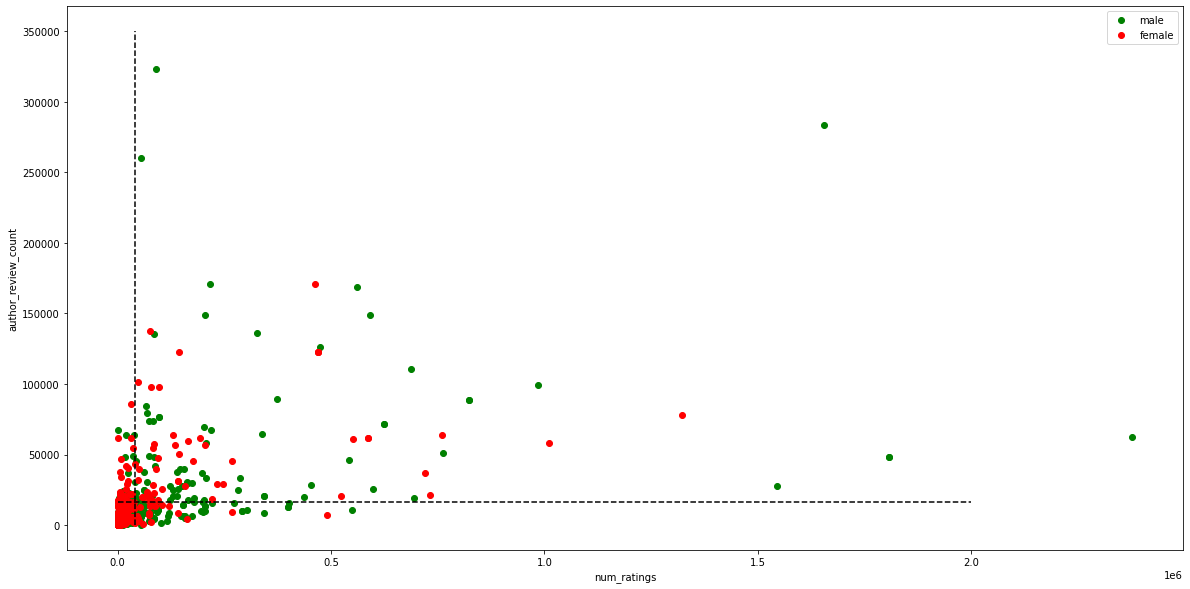

In [ ]:
# isolating labels
US_f_df = df4[df4['author_gender'] == 'female']
US_m_df = df4[df4['author_gender'] == 'male']

# scatter plot of the data
plt.figure(figsize = (20, 10))
plt.plot(US_m_df['num_ratings'], US_m_df['author_review_count'], 'go')
plt.plot(US_f_df['num_ratings'], US_f_df['author_review_count'], 'ro')
plt.xlabel('num_ratings')
plt.ylabel('author_review_count')
plt.legend(['male', 'female'])

# plotting the decision surfaces
# pages
plt.plot([40063,40063], [0,350000], 'k--')
plt.plot([0,2000000], [16688,16688], 'k--')

### **3. Comparison**

In [ ]:
print("Outside U.S.:\n{:3.2f} ({:3.2f},{:3.2f})".format(n_US_tree_acc,n_US_tree_lb,n_US_tree_ub))
print('')
print("Inside U.S.:\n{:3.2f} ({:3.2f},{:3.2f})".format(US_tree_acc,US_tree_lb,US_tree_ub))

Outside U.S.:
0.65 (0.61,0.69)

Inside U.S.:
0.99 (0.99,1.00)


Above are the accuracy scores and confidence intervals for the decision tree models built for authors born inside the U.S. and outside the U.S. 

For authors born in the U.S., their gender can be predicted based on popularity ie number of ratings. Male authors are more popular in the U.S.

For authors outside of the U.S., their gender can be predicted based on the rating of the actual book. 

# **4. Conclusions/Discussion**

## **1. Is there a discrepancy in the ratings for male versus female authors, or are they equal?**

As discussed in 3A, there is little difference in ratings between male and female authors. 

In [ ]:
print('Average Author Rating (0 - 5) Difference: {}'.format(m_aut_avg - f_aut_avg))
print('Average Book Rating (0 - 5) Difference: {}'.format(m_bk_avg - f_bk_avg))

Average Author Rating (0 - 5) Difference: 0.013322495367642961
Average Book Rating (0 - 5) Difference: 0.020504973900127066


The difference between male and female author ratings is .008 and the difference between male and female book ratings is .004. This suggests that male and female authors are rated nearly equally. This gives more weight to the factors that predict the author's gender.

## **2. Is there a trend in readers' taste based on gender? ie Can a book's author's gender be predicted from parts of a book review? If so, which factors**

From analysis of the overall dataset, **yes**. Recall the accuracy scores for the **KNN** and **Decision Tree** models:

In [ ]:
print("KNN:\n{:3.2f} ({:3.2f},{:3.2f})".format(acc_KNN,lb_KNN,ub_KNN))
print("")
print("Decision Tree:\n{:3.2f} ({:3.2f},{:3.2f})".format(tree_acc,tree_lb,tree_ub))

KNN:
0.76 (0.75,0.78)

Decision Tree:
0.77 (0.75,0.79)


According to the **KNN model**, points could be classified with 3 neighbors. This suggests that there is a clustering of author genders within the dataset.

According the **Decision Tree**, the major factors in predicting author gender were: 
* pages
* num_ratings
* author_rating_count

The number of pages in the decision tree was higher than average:

In [ ]:
# get average book length
X['pages'].mean()

319.00567644276254

The average book in the dataset has 333 pages. Even if the book is almost twice as long as average, if there are not many ratings then the author is likely to be **female**. 

**Male** authors are rated much more frequently than **female** authors who write books with the same number of pages. This suggests that **male** authors are more popular than **female** authors, even though their is no discrepancy in the actual book and author ratings. Considering that the **author_gender** variable is balanced, **female** authors who write longer books are overlooked. 

It is important to note that the dataset is made up of the most popular and highly regarded books on Goodreads. Assuming most of these are the unofficial Western canon of **male** authors which tend to be long. **Male** authors are allowed to write longer books, but the book has to be shorter for **female** authors to get attention.

## **3. Are these factors the same for authors born in the United States versus other countries?**

For authors born in the U.S., the major factors in predicting gender were solely based on popularity: **num_ratings** and **average_author_rating**. This is consistent with the second level factors of the overall dataset.

For authors born outside the U.S., the major factor was **book_average_rating**. This model was flawed and categorized all authors as **male**. It is interesting that this model was the only model to have the book rating as a major factor. Even in the decision tree without a specified depth, the first few levels all related to actual ratings (Appendix 2.3). 

The author_gender variable was not as balanced for this subset, so this needs further investigation. This suggests that it does not matter how popular the book is, but the attitude of Goodreads users in the U.S. alone towards authors born outside of the U.S.. There is a slight bias in U.S. readers to rate male authors born outside of the U.S. higher than female authors born outside of the U.S..

## **4. Closing**

Female authors in the U.S. face difficulty in being noticed overall, but do not face the same scrutiny that people born outside of the U.S., especially female authors, experience from U.S. readers. 

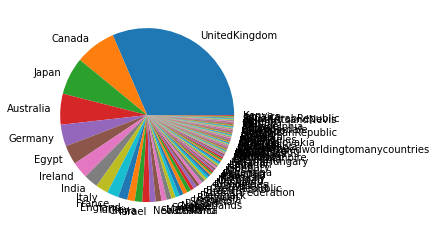

In [ ]:
# plot pie chart of labels
plot_series = df3['birthplace'].rename('')
plot_series.rename('').value_counts().plot.pie()

In looking at the breakdown of birthplaces outside the U.S. (above), most authors are European. A majority of the authors are from the United Kingdom. This is hardly diverse.

While there is no discrepancy in ratings between genders, women are still expected to perform differently. Male authors are given more leeway. Expectations are higher for authors born outside of the U.S., especially female authors. The U.S. has made progress internally regarding gender equality in literature, but still has ways to go for the attitude towards authors from the rest of the world.

A closer analysis is needed between ratings of authors from English-speaking /European countries and the rest of the world. It would also be beneficial to analyze the average user of Goodreads to get an idea of who exactly is reviewing the books. 

# **5. Appendix**

## 1. Statistics

The two graphs below illustrate the little difference between book ratings and author ratings in the overall dataset.

#### 1.1 Average book rating in dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


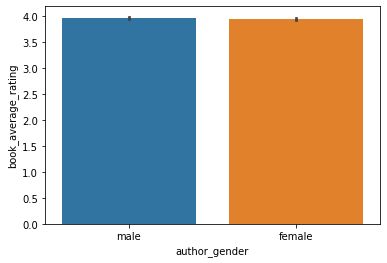

In [ ]:
sns.barplot(df2['author_gender'], df2['book_average_rating'])

#### 1.2 Average author rating in dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


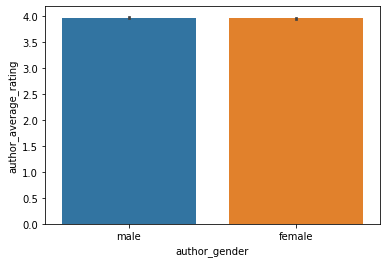

In [ ]:
sns.barplot(df2['author_gender'], df2['author_average_rating'])

## 2. Decision Tree

#### 2.1 Overall dataset decision tree for max depth

The max depth for the grid search over the dataset was needed. A decision tree without a max depth specified was used to find the max range.
The max tree depth is 26, so the range for the grid search is (1, 27).

In [ ]:
# build and train model
model = DecisionTreeClassifier(max_depth= None, random_state=1)
model.fit(X, y)

# print tree without limit on max depth to get range
tree_print(model, X)

# accuracy of best model with confidence interval
predict_y = model.predict(X)
acc = accuracy_score(y, predict_y)
lb,ub = classification_confint(acc,X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

if num_ratings =< 40063.0: 
  |then if author_review_count =< 899.0: 
  |  |then if author_average_rating =< 3.6350001096725464: 
  |  |  |then if author_average_rating =< 3.534999966621399: 
  |  |  |  |then if author_rating_count =< 1598.0: 
  |  |  |  |  |then if num_reviews =< 119.0: 
  |  |  |  |  |  |then male
  |  |  |  |  |  |else if author_review_count =< 177.0: 
  |  |  |  |  |  |  |then female
  |  |  |  |  |  |  |else male
  |  |  |  |  |else if author_review_count =< 395.0: 
  |  |  |  |  |  |then female
  |  |  |  |  |  |else if book_average_rating =< 3.659999966621399: 
  |  |  |  |  |  |  |then if book_average_rating =< 3.1350001096725464: 
  |  |  |  |  |  |  |  |then female
  |  |  |  |  |  |  |  |else male
  |  |  |  |  |  |  |else female
  |  |  |  |else male
  |  |  |else if author_rating_count =< 5093.5: 
  |  |  |  |then if author_review_count =< 361.5: 
  |  |  |  |  |then if num_reviews =< 73.0: 
  |  |  |  |  |  |then if num_reviews =< 56.5: 
  |  |  |  |  |  

### 2.2 Overall dataset Decision tree model decision surfaces

Below are the plotted decision surfaces for the optimal decision tree for the overall dataset.

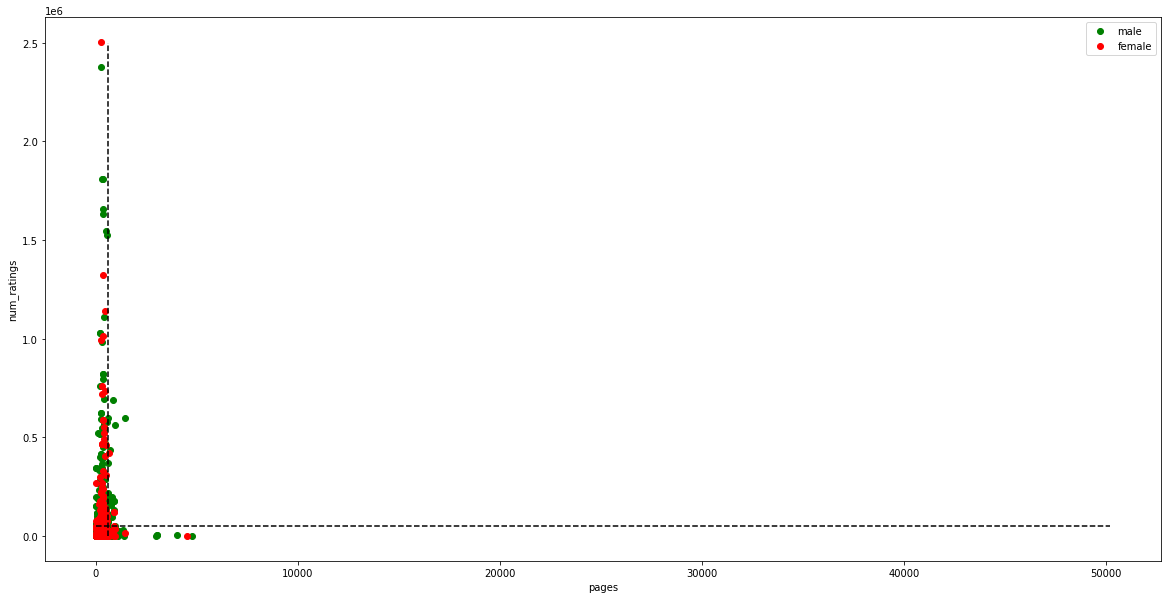

In [ ]:
# isolating labels
f_df = df2[df2['author_gender'] == 'female']
m_df = df2[df2['author_gender'] == 'male']

# scatter plot of the data
plt.figure(figsize = (20, 10))
plt.plot(m_df['pages'], m_df['num_ratings'], 'go')
plt.plot(f_df['pages'], f_df['num_ratings'], 'ro')
plt.xlabel('pages')
plt.ylabel('num_ratings')
plt.legend(['male', 'female'])

# plotting the decision surfaces
# pages
plt.plot([591,591], [0,2500000], 'k--')
plt.plot([0,50216], [50216,50216], 'k--')

### 2.3 Authors outside of U.S. max depth

The max depth for the grid search over the authors born outside the U.S. was needed. A decision tree without a max depth specified was used to find the max range.
The max tree depth is 24, so the range for the grid search is (1, 25).

In [ ]:
# get data
X  = df3.drop(['author_gender', 'author_name', 'book_title', 'birthplace', 'genre_1', 'genre_2'], axis = 1)
y = df3['author_gender']

# build and train model
model = DecisionTreeClassifier(max_depth=None, random_state=1)
model.fit(X, y)

# print tree without limit on max depth to get range
tree_print(model, X)

if book_average_rating =< 4.055000066757202: 
  |then if author_average_rating =< 3.6850000619888306: 
  |  |then if book_average_rating =< 3.3049999475479126: 
  |  |  |then if book_average_rating =< 3.1549999713897705: 
  |  |  |  |then if author_average_rating =< 3.0850000381469727: 
  |  |  |  |  |then if num_reviews =< 153.5: 
  |  |  |  |  |  |then male
  |  |  |  |  |  |else female
  |  |  |  |  |else male
  |  |  |  |else female
  |  |  |else if author_review_count =< 20.0: 
  |  |  |  |then female
  |  |  |  |else if num_reviews =< 84.0: 
  |  |  |  |  |then male
  |  |  |  |  |else if num_ratings =< 481.0: 
  |  |  |  |  |  |then female
  |  |  |  |  |  |else if author_rating_count =< 2997.5: 
  |  |  |  |  |  |  |then if num_ratings =< 787.5: 
  |  |  |  |  |  |  |  |then male
  |  |  |  |  |  |  |  |else female
  |  |  |  |  |  |  |else if num_ratings =< 3603.5: 
  |  |  |  |  |  |  |  |then male
  |  |  |  |  |  |  |  |else if num_ratings =< 5128.0: 
  |  |  |  |  |  |  | 

### 2.4 Authors within U.S. max depth

The max depth for the grid search over the authors born inside the U.S. was needed. A decision tree without a max depth specified was used to find the max range.
The max tree depth is 22, so the range for the grid search is (1, 23).

In [ ]:
# get data
X  = df4.drop(['author_gender', 'author_name', 'book_title', 'birthplace', 'genre_1', 'genre_2'], axis = 1)
y = df4['author_gender']

# build and train model
model = DecisionTreeClassifier(max_depth= None, random_state=1)
model.fit(X, y)

# print tree without limit on max depth to get range
tree_print(model, X)

if num_ratings =< 40063.0: 
  |then if author_review_count =< 899.0: 
  |  |then if author_average_rating =< 3.6350001096725464: 
  |  |  |then if author_average_rating =< 3.534999966621399: 
  |  |  |  |then if author_rating_count =< 1598.0: 
  |  |  |  |  |then if num_reviews =< 119.0: 
  |  |  |  |  |  |then male
  |  |  |  |  |  |else if author_review_count =< 177.0: 
  |  |  |  |  |  |  |then female
  |  |  |  |  |  |  |else male
  |  |  |  |  |else if author_review_count =< 395.0: 
  |  |  |  |  |  |then female
  |  |  |  |  |  |else if book_average_rating =< 3.659999966621399: 
  |  |  |  |  |  |  |then if book_average_rating =< 3.1350001096725464: 
  |  |  |  |  |  |  |  |then female
  |  |  |  |  |  |  |  |else male
  |  |  |  |  |  |  |else female
  |  |  |  |else male
  |  |  |else if author_rating_count =< 5093.5: 
  |  |  |  |then if author_review_count =< 361.5: 
  |  |  |  |  |then if num_reviews =< 73.0: 
  |  |  |  |  |  |then if num_reviews =< 56.5: 
  |  |  |  |  |  

## ANN Grid Search

### 3.1 ANN with "relu"

In [ ]:
# neural network
# NOTE: a good rule of thumb for MLP starting point:
# a) 1 hidden layer
# b) the number of nodes in hidden layer: no_node = 2 * no_independents_vars
# 2 * 7 = 14
ANN_model = MLPClassifier(hidden_layer_sizes=(14,), activation='relu', max_iter=1000, random_state=1)

# train and test the model
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=3)
ANN_model.fit(train_X, train_y)
ANN_predict_y = ANN_model.predict(X)

# accuracy score
ANN_acc = accuracy_score(y, ANN_predict_y)
ANN_lb, ANN_ub = classification_confint(ANN_acc, test_X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(ANN_acc, ANN_lb, ANN_ub))
print("")

# build the confusion matrix
labels = ['male', 'female']
ANN_cm = confusion_matrix(y, ANN_predict_y, labels=labels)
ANN_cm_df = pd.DataFrame(ANN_cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(ANN_cm_df))

Accuracy: 0.62 (0.56, 0.69)

Confusion Matrix:
        male  female
male     405     167
female   232     253


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


With "**relu**" as the activation, there is a slightly higher accuracy score (57%) compared to **tanh** but the confidence intervals mostly overlap, so it is not statistically significant. It is important to note that when comparing the confusion matrices, the number of **female** authors are categorized more accurately with "**relu**" than "**tanh**". Both activation types still lean towards categorizing authors as **male**, regardless of their actual gender.

### 3.2 ANN grid search

Below is the code from the ANN grid search. The code is purposefully provided as text to avoid accidentally running it.



```
# neural network
MLP_model = MLPClassifier(max_iter=10000, random_state=1)

# grid search
# 7 independent variables * 2 = 14 nodes
MLP_param_grid = {'hidden_layer_sizes': [ (7,), (14,), (28,),
                                      (7,7), (7,14), (7,28),
                                      (14,7), (14,14), (14,28),
                                      (28,7), (28,14), (28,28)
                                      ],
                                      'activation' : ['logistic','tanh','relu']
             }
MLP_grid = GridSearchCV(MLP_model, MLP_param_grid, cv=5)
MLP_grid.fit(X, actual_y)
print("Grid Search: best parameters: {}".format(MLP_grid.best_params_))

# evaluate the best model
MLP_best_model = MLP_grid.best_estimator_
MLP_predict_y = MLP_best_model.predict(X)
MLP_acc = accuracy_score(actual_y, MLP_predict_y)
MLP_lb,MLP_ub = classification_confint(MLP_acc,X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(MLP_acc,MLP_lb,MLP_ub))

# build the confusion matrix
labels = ['male', 'female']
MLP_cm = confusion_matrix(actual_y, MLP_predict_y, labels=labels)
MLP_cm_df = pd.DataFrame(MLP_cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(MLP_cm_df))
```

